### Project 2: Ames Housing Data and Kaggle Challenge

 # Data Cleaning

## Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression

%matplotlib inline
pd.set_option('display.max_columns', None)

In [76]:
config InlineBackend.figure_format = 'retina'

## **Read in Data**

In [77]:
kaggle = pd.read_csv("./datasets/test.csv", na_values = '', keep_default_na = False)
train = pd.read_csv("./datasets/train.csv", na_values = '', keep_default_na = False)

In [78]:
train.shape

(2051, 81)

In [79]:
kaggle.shape

(878, 80)

## Quick Fixes

#### **Snake Case Column Names**

In [80]:
train.columns = train.columns.str.lower().str.replace(' ', '_')
kaggle.columns = kaggle.columns.str.lower().str.replace(' ', '_')

In [81]:
train.groupby('roof_matl')['saleprice'].mean()

roof_matl
ClyTile    160000.000000
CompShg    180849.197037
Membran    241500.000000
Tar&Grv    187948.933333
WdShake    264250.000000
WdShngl    339400.000000
Name: saleprice, dtype: float64

In [82]:
train['roof_matl'].value_counts()

CompShg    2025
Tar&Grv      15
WdShngl       5
WdShake       4
Membran       1
ClyTile       1
Name: roof_matl, dtype: int64

In [83]:
train['mas_vnr_type'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [84]:
train.groupby('mas_vnr_type')['saleprice'].mean()

mas_vnr_type
BrkCmn     144515.692308
BrkFace    212161.436508
None       153679.275862
Stone      263714.702381
Name: saleprice, dtype: float64

#### **Reassign columns describing quality and condition with numerical rankings** 

In [85]:
cond_cols = list(train.columns[(train.columns.str.contains('cond')) | (train.columns.str.contains('qual'))])

In [86]:
cond_cols

['condition_1',
 'condition_2',
 'overall_qual',
 'overall_cond',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'low_qual_fin_sf',
 'kitchen_qual',
 'garage_qual',
 'garage_cond']

Create a data dictionary to replace rankings with

In [87]:
cat_replace_dict = {'Ex':5,
                    'Gd':4,
                    'TA':3,
                    'Fa':2,
                    'Po':1,
                    'NA':0}

In [88]:
train.loc[:, cond_cols] = train.loc[:, cond_cols].replace(cat_replace_dict)
kaggle.loc[:, cond_cols] = kaggle.loc[:, cond_cols].replace(cat_replace_dict)

**Very few houses have a value in Pool Quality, so I will drop that column**

In [89]:
train.drop(columns='pool_qc', inplace=True)

In [90]:
kaggle.drop(columns='pool_qc', inplace=True)

## **Resolve Remaining Null Values**

### **Lot Frontage Nulls**

I am assuming that columns that are null for lot frontage were meant to be zero. To confirm this, I am going to make three columns, one with the nan lot frontages replaced with zero and one with the nans replaced with the mean. Then I will use both to predict price and see which one performs better

In [91]:
# top five highest correlating features to be used in the test
top5 = ['overall_qual',
        'exter_qual',
        'gr_liv_area',
        'kitchen_qual',
        'lot_frontage']

Lot Frontage set to zero

In [92]:
X_lot_zero = train[top5]
X_lot_zero.loc[X_lot_zero['lot_frontage'].isnull(),'lot_frontage'] = X_lot_zero.loc[X_lot_zero['lot_frontage'].isnull(),'lot_frontage'].copy().replace(np.nan, 0)
y_lot_zero = train['saleprice']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Lot Frontage set to the mean

In [93]:
lot_mean = train.loc[~train['lot_frontage'].isnull(), 'lot_frontage'].mean()

In [94]:
X_lot_mean = train[top5]
X_lot_mean.loc[X_lot_mean['lot_frontage'].isnull(),'lot_frontage'] = lot_mean
y_lot_mean = train['saleprice']

Set up a linear regression model for **Zero Lot Frontage**

In [95]:
model_zero = LinearRegression()

In [96]:
model_zero.fit(X_lot_zero, y_lot_zero)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
print(f"Lot-zero R2: {model_zero.score(X_lot_zero, y_lot_zero)}")

Lot-zero R2: 0.7691947021137837


Set up a linear regression model for **Mean Lot Frontage**

In [98]:
model_mean = LinearRegression()

In [99]:
model_mean.fit(X_lot_mean, y_lot_mean)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
print(f"Lot-mean R2: {model_mean.score(X_lot_mean, y_lot_mean)}")

Lot-mean R2: 0.7758473524198215


Since the model using the mean of lot frontage was slightly better, I will use the mean to replace lot frontage.

In [101]:
train.loc[train['lot_frontage'].isnull(), 'lot_frontage'] = lot_mean

In [102]:
kaggle.loc[kaggle['lot_frontage'].isnull(), 'lot_frontage'] = lot_mean

**Garage year built nulls**

In [103]:
train.loc[train['garage_yr_blt'].isnull(),:].head(3)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
28,2243,911103060,190,C (all),75.0,8250,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,2fmCon,2Story,5,6,1895,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3.0,3.0,No,Unf,0.0,Unf,0.0,957.0,957.0,GasA,Fa,N,SBrkr,1034,957,0,1991,0.0,0.0,2,0,4,2,3,9,Typ,0,NA,NA,NaN,NA,0.0,0.0,0.0,0.0,N,0,0,133,0,0,0,NA,NA,0,6,2007,WD,119600
53,330,923226250,160,RM,21.0,1476,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,3,3,CBlock,3.0,3.0,No,GLQ,176.0,Unf,0.0,370.0,546.0,GasA,Ex,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,Typ,0,NA,NA,NaN,NA,0.0,0.0,0.0,0.0,Y,200,26,0,0,0,0,NA,NA,0,3,2010,WD,76000
65,2278,923202134,20,RL,70.0,8402,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Feedr,Norm,1Fam,1Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4.0,3.0,No,ALQ,206.0,Unf,0.0,914.0,1120.0,GasA,Ex,Y,SBrkr,1120,0,0,1120,0.0,0.0,1,0,3,1,3,6,Typ,0,NA,NA,NaN,NA,0.0,0.0,0.0,0.0,Y,0,30,0,0,0,0,NA,NA,0,12,2007,New,147000


In [104]:
train.loc[(train['garage_yr_blt'].isnull()) & (train['garage_type'] != 'NA'),:]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,BrkTil,4.0,3.0,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,4,6,Typ,0,NA,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,MnPrv,NA,0,3,2007,WD,150909


Since the houses with NaN garage year built values almost all have no garage except for one, I will fill them with the mean year from the kaggle and training set

In [105]:
garage_train_mean = train.loc[~train['garage_yr_blt'].isnull(), 'garage_yr_blt'].mean()
garage_test_mean = kaggle.loc[~kaggle['garage_yr_blt'].isnull(), 'garage_yr_blt'].mean()

garage_yr_mean = (garage_train_mean + garage_test_mean) / 2

In [106]:
train.loc[train['garage_yr_blt'].isnull(), 'garage_yr_blt'] = garage_yr_mean
kaggle.loc[kaggle['garage_yr_blt'].isnull(), 'garage_yr_blt'] = garage_yr_mean

**Masonry Veneer Nulls**

Since all of the houses with NaN in masonry veneer area also have NaN in masonry veneer type, I will assume that they meant to say that there was no masonry veneer. I will replace type with 'None', and area with 0. 

In [107]:
train.loc[train['mas_vnr_area'].isnull(), 'mas_vnr_area'] = 0
train.loc[train['mas_vnr_type'].isnull(), 'mas_vnr_type'] = 'None'

In [108]:
kaggle.loc[kaggle['mas_vnr_area'].isnull(), 'mas_vnr_area'] = 0
kaggle.loc[kaggle['mas_vnr_type'].isnull(), 'mas_vnr_type'] = 'None'

**Basement Nulls**

Replace all NaNs with zero 

In [109]:
train.loc[train['bsmt_exposure'].isnull(), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1327,1342,903230120,20,RM,99.0,5940,Pave,NA,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,3,3,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,3,4,Typ,0,NA,Detchd,1946.0,Unf,1.0,280.0,3.0,3.0,Y,0,0,0,0,0,0,MnPrv,NA,0,4,2008,ConLD,79000
1456,1797,528458090,60,FV,81.0,10411,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,CBlock,4.0,3.0,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,4,8,Typ,0,NA,Attchd,2007.0,Unf,2.0,561.0,3.0,3.0,Y,0,0,0,0,0,0,NA,NA,0,7,2007,New,212109
1547,67,528445060,20,RL,73.0,8987,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,4,3,PConc,4.0,3.0,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,4,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,3.0,3.0,Y,144,0,0,0,0,0,NA,NA,0,5,2010,WD,221500
1997,2780,907194130,60,RL,65.0,14006,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,4,3,PConc,4.0,3.0,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,840,0,1776,0.0,0.0,2,1,3,1,4,7,Typ,1,TA,Attchd,2002.0,RFn,2.0,474.0,3.0,3.0,Y,144,96,0,0,0,0,NA,NA,0,2,2006,WD,192500


In [110]:
# fix the faulty basement description in row 1327
train.loc[1327, 'bsmt_exposure'] = 'NA'
train.loc[1327, 'bsmt_cond'] = 0 
train.loc[1327, 'bsmt_qual'] = 0 
train.loc[1327, 'bsmtfin_type_1'] = 'Unf'
train.loc[1327, 'bsmtfin_sf_1'] = 0 
train.loc[1327, 'bsmtfin_type_2'] = 'Unf'
train.loc[1327, 'bsmtfin_sf_2'] = 0
train.loc[1327, 'bsmt_unf_sf'] = train.loc[~train['bsmt_unf_sf'].isnull(), 'bsmt_unf_sf'].mean()
train.loc[1327, 'total_bsmt_sf'] = train.loc[~train['total_bsmt_sf'].isnull(), 'total_bsmt_sf'].mean()
train.loc[1327, 'bsmt_full_bath'] = 0
train.loc[1327, 'bsmt_half_bath'] = 0

All remaining basement exposure columns with nulls should say "No"

In [111]:
train.loc[train['bsmt_exposure'].isnull(), 'bsmt_exposure'] = 'No'

Fill in last three basement errors

In [112]:
train.loc[(train['bsmtfin_type_2'].isnull()) | (train['bsmt_half_bath'].isnull()), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
616,1498,908154080,20,RL,123.0,47007,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,3,3,Slab,0.0,0.0,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,5,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,3.0,3.0,Y,0,372,0,0,0,0,NA,NA,0,7,2008,WD,284700
1147,445,528142130,20,RL,85.0,10655,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,4,3,PConc,4.0,3.0,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,GasA,Ex,Y,SBrkr,1629,0,0,1629,1.0,0.0,2,0,3,1,4,7,Typ,1,Gd,Attchd,2003.0,RFn,3.0,880.0,3.0,3.0,Y,0,0,0,0,0,0,NA,NA,0,10,2009,WD,284000


In [113]:
train.loc[1147, 'bsmtfin_type_2'] = 'GLQ'

train.loc[616, 'bsmt_full_bath'] = 0
train.loc[616, 'bsmt_half_bath'] = 0

**Last Five Garage Nulls**

In [114]:
train.loc[train['garage_finish'].isnull(), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,BrkTil,4.0,3.0,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,4,6,Typ,0,NA,Detchd,1977.73385,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,MnPrv,NA,0,3,2007,WD,150909


The remaining nulls are from one house. All of the garage variables are null but there is a garage. This row will be dropped

In [115]:
train.shape

(2051, 80)

In [116]:
train.drop(1712, axis=0, inplace=True)

Check to make sure there are no more nulls in the training set

In [117]:
train.isnull().sum().sum()

0

**Fix the final two nulls in the test set**

In [118]:
kaggle.loc[(kaggle['garage_finish'].isnull()) | (kaggle['electrical'].isnull()), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
634,1578,916386080,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,4,7,Typ,0,NA,BuiltIn,2007.00000,Fin,2,400,3,3,Y,100,0,0,0,0,0,NA,NA,0,5,2008,WD
764,1357,903426160,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,PConc,3,3,Mn,Rec,196,Unf,0,1046,1242,GasA,Gd,Y,SBrkr,1242,742,0,1984,0,0,2,0,5,1,3,8,Typ,0,NA,Detchd,1977.73385,NaN,1,360,0,0,Y,64,0,180,0,0,0,MnPrv,Shed,1000,9,2008,WD


Make the garage finish null 'Unf'

In [119]:
kaggle.loc[764, 'garage_finish'] = 'Unf'

In [120]:
kaggle.loc[kaggle['electrical'].isnull(),:]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
634,1578,916386080,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,4,7,Typ,0,NA,BuiltIn,2007.0,Fin,2,400,3,3,Y,100,0,0,0,0,0,NA,NA,0,5,2008,WD


In [121]:
kaggle['electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

Replace the missing electrical value with the most common one 'SBrkr'

In [122]:
kaggle.loc[634, 'electrical'] = 'SBrkr'

Check to make sure there are no more nulls in the test set

In [123]:
kaggle.isnull().sum().sum()

0

### Map a custom dictionary to all remaining columns with ordinal components

Should be 54 less columns in the master cleaned or 210?

In [124]:
ordinal_dictionary = {
    'utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'bsmtfin_type_1': {'GLQ': 7, 'ALQ': 6, 'BLQ': 5, 'NA': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1},
    'bsmtfin_type_2': {'GLQ': 7, 'ALQ': 6, 'BLQ': 5, 'NA': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1},
    'heating_qc': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'central_air': {'Y': 1, 'N': 0},
    'functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'fireplace_qu': {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0},
    'garage_finish': {'Fin': 4, 'RFn': 3, 'Unf': 2, 'NA': 1},
    'paved_drive': {'Y': 3, 'P': 2, 'N': 1}
}

Loop through each column and map its corresponding dictionary to the train and the test set

In [125]:
for key in ordinal_dictionary:
    train[key] = train[key].replace(ordinal_dictionary[key])
    kaggle[key] = kaggle[key].replace(ordinal_dictionary[key])

Fix the faulty columns that are still objects and not int

In [126]:
# first fix the train object column there is only 1
train['utilities'] = train['utilities'].astype(int)

In [127]:
# now fix the kaggle object columns, there are 3
kaggle['utilities'] = kaggle['utilities'].astype(int)
kaggle['heating_qc'] = kaggle['heating_qc'].astype(int)
kaggle['functional'] = kaggle['functional'].astype(int)

### Create Dummy Variables for all Categorical Variables

Combine train and kaggle before making the dummy columns so that their final shapes are equal and all dummies match up

In [128]:
import warnings
warnings.simplefilter(action="ignore")

In [129]:
train['train?'] = 1
kaggle['train?'] = 0
kaggle['saleprice'] = 0

In [130]:
train.shape, kaggle.shape

((2050, 81), (878, 81))

In [131]:
original_columns = list(train.columns)

In [132]:
train_test = pd.merge(left=train, right=kaggle, how='outer', on=original_columns)

Use pd.get_dummies to make dummy columns for all 34 categorical variables

In [133]:
# make a list of all column names to put into the get dummies statement
final_dummies = list(train.select_dtypes(include='object').columns)

In [134]:
train_test_dummy_master = pd.get_dummies(train_test, columns = final_dummies, drop_first=True)

Now split the dummy master back into the train and the test sets

In [135]:
train_cleaned = train_test_dummy_master.loc[train_test_dummy_master['train?'] == 1, :]
kaggle_cleaned = train_test_dummy_master.loc[train_test_dummy_master['train?'] == 0, :]

Check to make sure their shapes line up

In [136]:
train_cleaned.shape, kaggle_cleaned.shape

((2050, 219), (878, 219))

Remove the saleprice column from the test cleaned set

In [137]:
kaggle_cleaned.drop(columns='saleprice', inplace=True)

Remove the Train? identifier from both columns

In [138]:
train_cleaned.drop(columns='train?', inplace=True)
kaggle_cleaned.drop(columns='train?', inplace=True)

In [139]:
kaggle_cleaned.shape

(878, 217)

Check to make sure there are no more object columns

In [140]:
kaggle_cleaned.dtypes.value_counts()

uint8      163
int64       39
float64     15
dtype: int64

In [141]:
train_cleaned.dtypes.value_counts()

uint8      163
int64       40
float64     15
dtype: int64

### look at the distribution of sale price

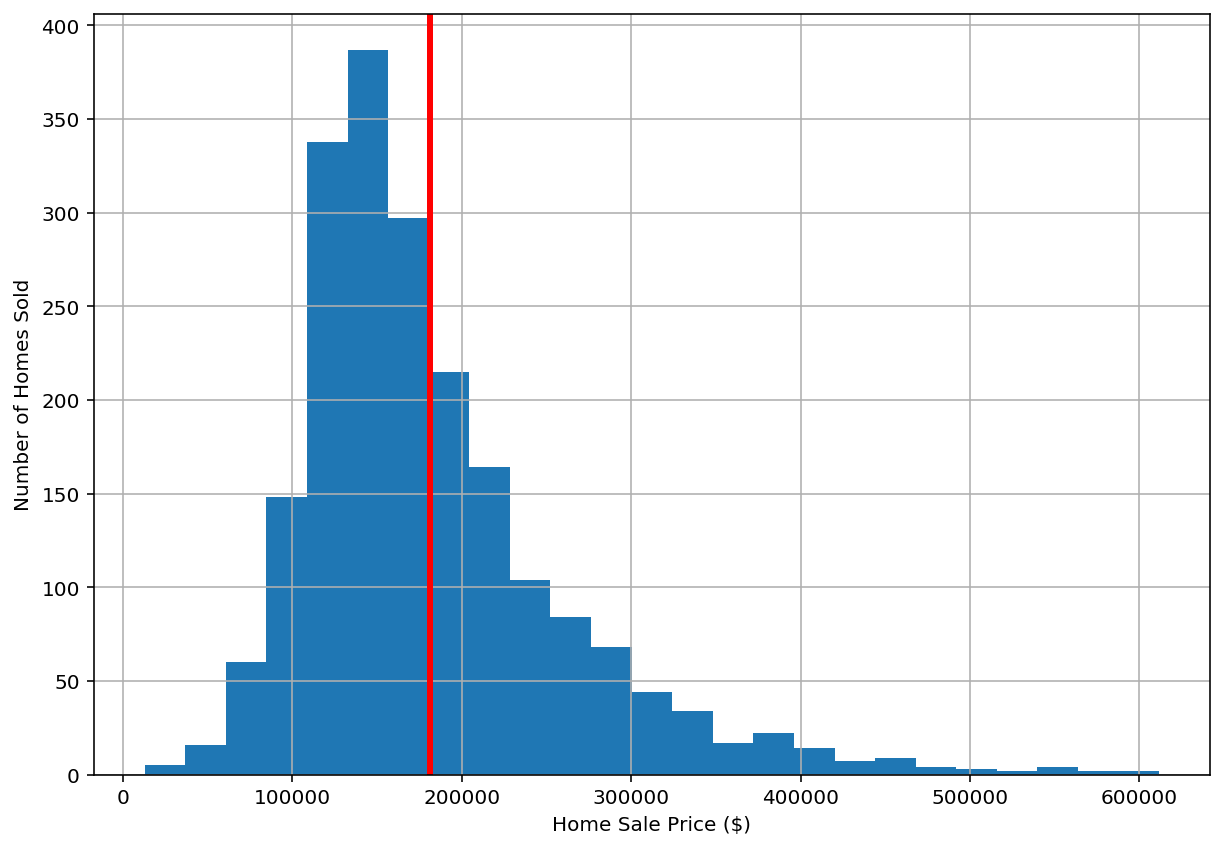

In [142]:
train_cleaned['saleprice'].hist(bins=25, figsize=(10,7))
plt.xlabel("Home Sale Price ($)")
plt.ylabel('Number of Homes Sold')
plt.axvline(x=train_cleaned['saleprice'].mean(), color='red', linewidth=3)

### Write the Cleaned Datasets to the Datasets folder 

In [62]:
train_cleaned.to_csv('./datasets/cleaned_training_data.csv')
kaggle_cleaned.to_csv('./datasets/cleaned_testing_data.csv')